Cell 1

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from dataclasses import dataclass
from typing import List, Tuple
import pandas as pd
import time
from scipy.optimize import curve_fit

# Set random seed for reproducibility
np.random.seed(42)

# Simulation parameters
GRID_SIZE = 0.5  # km x km (500m x 500m)
POPULATION_DENSITY = 4534  
N_AGENTS = int(POPULATION_DENSITY * GRID_SIZE ** 2)  # 750 agents

# Movement parameters
AVERAGE_DISTANCE_TRAVELLED = 0.92  # km per day (walking only, from research)
DT = 1.0  # Time step = 1 day

# Calculate diffusion coefficient from average distance traveled
# For 2D Brownian motion: RMS displacement = sqrt(4*D*t)
# Therefore: D = (RMS displacement)^2 / (4*t)
# We assume average distance ≈ RMS displacement
D = (AVERAGE_DISTANCE_TRAVELLED ** 2) / (4 * DT)

SIMULATION_DAYS = 50

# Disease parameters
PEAK_INFECTIOUSNESS_DAY, INFECTIOUSNESS_STD = (7,3)  
INFECTIOUSNESS_THRESHOLD = 0.05  # Below this, person recovers
INITIAL_INFECTED = 1
DECAY_MULTIPLIER = 1.0  # Controls how fast infectiousness decays after peak

# Transmission parameters
MAX_TRANSMISSION_DISTANCE = 0.10  # Check agents within 100 meters

print(f"Simulation setup:")
print(f"Grid size: {GRID_SIZE} km x {GRID_SIZE} km")
print(f"Population: {N_AGENTS} agents")
print(f"Effective density: {N_AGENTS / (GRID_SIZE**2):.0f} per km²")
print(f"Average agent spacing: ~{np.sqrt((GRID_SIZE**2)/N_AGENTS)*1000:.1f} meters")
print(f"\nMovement parameters:")
print(f"Average distance travelled per day: {AVERAGE_DISTANCE_TRAVELLED} km")
print(f"Calculated diffusion coefficient D: {D:.4f} km²/day")
print(f"Expected daily RMS movement: {np.sqrt(4*D*DT):.2f} km")
print(f"\nTransmission parameters:")
print(f"Max transmission distance: {MAX_TRANSMISSION_DISTANCE*1000:.0f} meters")
print(f"Decay multiplier: {DECAY_MULTIPLIER} (1.0 = normal, <1 = longer recovery, >1 = shorter recovery)")


Simulation setup:
Grid size: 0.5 km x 0.5 km
Population: 1133 agents
Effective density: 4532 per km²
Average agent spacing: ~14.9 meters

Movement parameters:
Average distance travelled per day: 0.92 km
Calculated diffusion coefficient D: 0.2116 km²/day
Expected daily RMS movement: 0.92 km

Transmission parameters:
Max transmission distance: 100 meters
Decay multiplier: 1.0 (1.0 = normal, <1 = longer recovery, >1 = shorter recovery)


Cell 2

In [47]:
@dataclass
class Agent:
    """Represents a person in the simulation"""
    x: float
    y: float
    status: str
    days_infected: int = 0
    infected_by_generation: int = -1
    decay_multiplier: float = None  # Must be provided
    grid_size: float = None  # Must be provided
    
    def __post_init__(self):
        """Validate that required parameters are provided"""
        if self.decay_multiplier is None:
            self.decay_multiplier = DECAY_MULTIPLIER  # Use global default
        if self.grid_size is None:
            self.grid_size = GRID_SIZE  # Use global default
    
    def move(self, D, dt):
        """Update position based on Brownian motion"""
        sigma = np.sqrt(2 * D * dt)
        dx = np.random.normal(0, sigma)
        dy = np.random.normal(0, sigma)
        
        # Update position with periodic boundary conditions
        self.x = (self.x + dx) % self.grid_size
        self.y = (self.y + dy) % self.grid_size
    
    def get_infectiousness(self):
        """Calculate infectiousness as function of days since infection with decay multiplier"""
        if self.status != 'infected':
            return 0.0
        
        mean = PEAK_INFECTIOUSNESS_DAY
        std = INFECTIOUSNESS_STD
        
        # Always calculate the base Gaussian value
        gaussian_value = norm.pdf(self.days_infected, mean, std) / norm.pdf(mean, mean, std)
        
        if self.days_infected <= mean:
            # Before or at peak: use normal Gaussian (no modification)
            infectiousness = gaussian_value
        else:
            # After peak: apply decay multiplier
            peak_value = 1.0
            drop_from_peak = peak_value - gaussian_value
            adjusted_drop = drop_from_peak * self.decay_multiplier
            infectiousness = peak_value - adjusted_drop
        
        infectiousness = max(0.0, float(infectiousness))
        return infectiousness
    
    def update_infection_status(self):
        """Update infection progression"""
        if self.status == 'infected':
            self.days_infected += 1
            
            if self.get_infectiousness() < INFECTIOUSNESS_THRESHOLD:
                self.status = 'recovered'
                return True
        return False

def transmission_probability_distance(distance):
    """
    Transmission probability based on distance
    Calibrated to 15% at 3 meters when at peak infectiousness
    """
    if distance < 1e-6:
        distance = 1e-6
    
    characteristic_distance = 0.015  # 15 meters
    target_distance = 0.003  # 3 meters in km
    target_prob = 0.15
    base_rate = target_prob / np.exp(-target_distance / characteristic_distance)
    
    prob = base_rate * np.exp(-distance / characteristic_distance)
    
    return min(prob, 1.0)

print("Agent class and transmission functions defined!")

Agent class and transmission functions defined!


Cell 3

In [49]:
def initialize_population(n_agents, initial_infected, grid_size=GRID_SIZE, 
                         decay_multiplier=DECAY_MULTIPLIER, for_r0_calculation=False):
    """
    Initialize agents with random positions
    
    Args:
        n_agents: Number of agents
        initial_infected: Number of initially infected agents
        grid_size: Size of the grid (km x km)
        decay_multiplier: Decay multiplier for infectiousness
        for_r0_calculation: If True, mark generation appropriately
    """
    agents = []
    
    for i in range(n_agents):
        x = np.random.uniform(0, grid_size)
        y = np.random.uniform(0, grid_size)
        
        if i < initial_infected:
            # Initial infected are generation 0, start at peak infectiousness
            agent = Agent(x, y, 'infected', days_infected=PEAK_INFECTIOUSNESS_DAY, 
                         infected_by_generation=0, decay_multiplier=decay_multiplier,
                         grid_size=grid_size)
        else:
            agent = Agent(x, y, 'susceptible', decay_multiplier=decay_multiplier,
                         grid_size=grid_size)
        
        agents.append(agent)
    
    return agents

# Test initialization
test_agents = initialize_population(N_AGENTS, INITIAL_INFECTED)
print(f"Initialized {len(test_agents)} agents")
print(f"Initial infected: {sum(1 for a in test_agents if a.status == 'infected')}")
print(f"Initial infected person's infectiousness: {test_agents[0].get_infectiousness():.4f}")
print(f"Initial susceptible: {sum(1 for a in test_agents if a.status == 'susceptible')}")

Initialized 1133 agents
Initial infected: 1
Initial infected person's infectiousness: 1.0000
Initial susceptible: 1132


Cell 4

In [51]:
def calculate_distance(agent1, agent2):
    """Calculate distance between two agents considering periodic boundaries"""
    grid_size = agent1.grid_size  # Get grid size from agent
    dx = abs(agent1.x - agent2.x)
    dy = abs(agent1.y - agent2.y)
    
    # Account for periodic boundary (shortest distance)
    dx = min(dx, grid_size - dx)
    dy = min(dy, grid_size - dy)
    
    return np.sqrt(dx**2 + dy**2)

def calculate_distance_coords(x1, y1, x2, y2, grid_size):
    """Calculate distance between coordinates considering periodic boundaries"""
    dx = abs(x1 - x2)
    dy = abs(y1 - y2)
    
    dx = min(dx, grid_size - dx)
    dy = min(dy, grid_size - dy)
    
    return np.sqrt(dx**2 + dy**2)

def calculate_distances_vectorized(infected_x, infected_y, susceptible_positions, grid_size):
    """
    Vectorized distance calculation for one infected to all susceptible
    """
    dx = np.abs(susceptible_positions[:, 0] - infected_x)
    dy = np.abs(susceptible_positions[:, 1] - infected_y)
    
    # Handle periodic boundaries
    dx = np.minimum(dx, grid_size - dx)
    dy = np.minimum(dy, grid_size - dy)
    
    return np.sqrt(dx**2 + dy**2)

def attempt_transmission(infected_agent, susceptible_agent, max_distance):
    """
    Attempt to transmit infection from infected to susceptible agent
    Returns True if transmission occurs
    """
    distance = calculate_distance(infected_agent, susceptible_agent)
    
    # Skip if too far away (optimization)
    if distance > max_distance:
        return False
    
    p_distance = transmission_probability_distance(distance)
    p_infectiousness = infected_agent.get_infectiousness()
    
    p_transmission = p_distance * p_infectiousness
    
    if np.random.random() < p_transmission:
        return True
    
    return False

def transmission_step_optimized(agents, max_transmission_distance=MAX_TRANSMISSION_DISTANCE, 
                               for_r0_calculation=False):
    """
    Highly optimized transmission using vectorized operations
    """
    # Get infected and susceptible agents
    if for_r0_calculation:
        infected_agents = [a for a in agents if a.status == 'infected' and a.infected_by_generation == 0]
    else:
        infected_agents = [a for a in agents if a.status == 'infected']
    
    susceptible_agents = [a for a in agents if a.status == 'susceptible']
    
    if len(infected_agents) == 0 or len(susceptible_agents) == 0:
        return 0
    
    # Get grid size from first agent
    grid_size = agents[0].grid_size
    
    # Pre-compute susceptible positions as numpy array
    susceptible_positions = np.array([[a.x, a.y] for a in susceptible_agents])
    newly_infected_indices = set()
    
    # Check each infected agent
    for infected in infected_agents:
        # Vectorized distance calculation
        distances = calculate_distances_vectorized(infected.x, infected.y, 
                                                   susceptible_positions, grid_size)
        
        # Find nearby agents
        nearby_mask = distances <= max_transmission_distance
        nearby_indices = np.where(nearby_mask)[0]
        
        if len(nearby_indices) == 0:
            continue
        
        # Get infectiousness once per infected agent
        infectiousness = infected.get_infectiousness()
        
        # Vectorized transmission probability calculation
        nearby_distances = distances[nearby_indices]
        
        # Build transmission probabilities array
        transmission_probs = np.zeros(len(nearby_distances))
        for i, d in enumerate(nearby_distances):
            transmission_probs[i] = transmission_probability_distance(d) * infectiousness
        
        # Vectorized random roll for all nearby agents at once
        random_rolls = np.random.random(len(nearby_indices))
        successful_transmissions = nearby_indices[random_rolls < transmission_probs]
        
        # Mark newly infected (avoiding double-infection)
        for idx in successful_transmissions:
            if idx not in newly_infected_indices:
                newly_infected_indices.add(idx)
    
    # Apply infections
    new_infections = []
    for idx in newly_infected_indices:
        susceptible = susceptible_agents[idx]
        generation = infected_agents[0].infected_by_generation + 1
        new_infections.append((susceptible, generation))
    
    for agent, generation in new_infections:
        agent.status = 'infected'
        agent.days_infected = 0
        agent.infected_by_generation = generation
    
    return len(new_infections)

print("Highly optimized transmission logic defined!")
print(f"Using vectorized numpy operations for speed")

Highly optimized transmission logic defined!
Using vectorized numpy operations for speed


Cell 5

In [53]:
def simulate_r0(n_agents=N_AGENTS, grid_size=GRID_SIZE, decay_multiplier=DECAY_MULTIPLIER,
                max_transmission_distance=MAX_TRANSMISSION_DISTANCE, n_days=50, verbose=False):
    """
    Optimized R0 calculation with configurable parameters
    
    Args:
        n_agents: Number of agents in simulation
        grid_size: Size of grid (km x km)
        decay_multiplier: Infectiousness decay multiplier
        max_transmission_distance: Maximum distance for transmission attempts
        n_days: Maximum days to simulate
        verbose: Whether to print progress
    """
    agents = initialize_population(n_agents, INITIAL_INFECTED, grid_size=grid_size,
                                  decay_multiplier=decay_multiplier, for_r0_calculation=True)
    
    total_infections = 0
    
    for day in range(n_days):
        # Move all agents
        for agent in agents:
            agent.move(D, DT)
        
        # Attempt transmissions
        new_infections = transmission_step_optimized(agents, 
                                                     max_transmission_distance=max_transmission_distance,
                                                     for_r0_calculation=True)
        total_infections += new_infections
        
        # Update infection status
        for agent in agents:
            agent.update_infection_status()
        
        # Early stopping if generation-0 all recovered
        gen0_active = any(a.infected_by_generation == 0 and a.status == 'infected' for a in agents)
        if not gen0_active and day > 0:
            if verbose:
                print(f"Generation-0 recovered on day {day}")
            break
    
    r0 = total_infections / INITIAL_INFECTED
    
    if verbose:
        density = n_agents / (grid_size ** 2)
        print(f"R0 = {r0:.2f} (density={density:.0f}/km², grid={grid_size:.2f}km, decay={decay_multiplier:.2f})")
    
    return r0

# Single R0 run with output (using defaults)
print("="*60)
print("SINGLE R0 CALCULATION (Default Parameters)")
print("="*60)
start = time.time()
r0_value = simulate_r0(verbose=True)
end = time.time()
print(f"Computation time: {end-start:.2f} seconds")

# Multiple R0 runs for averaging (fast batch mode)
print("\n" + "="*60)
print("MULTIPLE R0 CALCULATIONS (20 runs with defaults)")
print("="*60)
start = time.time()
r0_values = [simulate_r0(verbose=False) for _ in range(20)]
end = time.time()

print(f"R0 values: {[f'{r:.2f}' for r in r0_values]}")
print(f"Mean R0: {np.mean(r0_values):.2f}")
print(f"Std R0: {np.std(r0_values):.2f}")
print(f"Range: [{np.min(r0_values):.2f}, {np.max(r0_values):.2f}]")
print(f"Total computation time: {end-start:.2f} seconds ({(end-start)/20:.2f} sec per run)")

SINGLE R0 CALCULATION (Default Parameters)
Generation-0 recovered on day 7
R0 = 4.00 (density=4532/km², grid=0.50km, decay=1.00)
Computation time: 0.04 seconds

MULTIPLE R0 CALCULATIONS (20 runs with defaults)
R0 values: ['1.00', '3.00', '8.00', '8.00', '7.00', '6.00', '4.00', '5.00', '6.00', '6.00', '4.00', '2.00', '4.00', '2.00', '7.00', '6.00', '7.00', '3.00', '1.00', '4.00']
Mean R0: 4.70
Std R0: 2.17
Range: [1.00, 8.00]
Total computation time: 0.85 seconds (0.04 sec per run)


cell 5a

R0 VS POPULATION DENSITY SWEEP
Fixed number of agents: 1133
Testing 10 different densities
Density range: 750 to 8500 people/km²
Runs per density: 20
Total simulations: 200

[1/10] Testing density = 750 people/km² (grid = 1.229 km)...
  Mean R0 = 1.00 ± 1.14 (time: 0.6s)

[2/10] Testing density = 1611 people/km² (grid = 0.839 km)...
  Mean R0 = 1.50 ± 1.60 (time: 0.5s)

[3/10] Testing density = 2472 people/km² (grid = 0.677 km)...
  Mean R0 = 2.45 ± 1.63 (time: 0.5s)

[4/10] Testing density = 3333 people/km² (grid = 0.583 km)...
  Mean R0 = 4.25 ± 1.97 (time: 0.6s)

[5/10] Testing density = 4194 people/km² (grid = 0.520 km)...
  Mean R0 = 5.65 ± 2.52 (time: 0.5s)

[6/10] Testing density = 5056 people/km² (grid = 0.473 km)...
  Mean R0 = 5.45 ± 2.75 (time: 0.6s)

[7/10] Testing density = 5917 people/km² (grid = 0.438 km)...
  Mean R0 = 6.25 ± 2.26 (time: 0.6s)

[8/10] Testing density = 6778 people/km² (grid = 0.409 km)...
  Mean R0 = 7.95 ± 3.07 (time: 0.6s)

[9/10] Testing density = 76

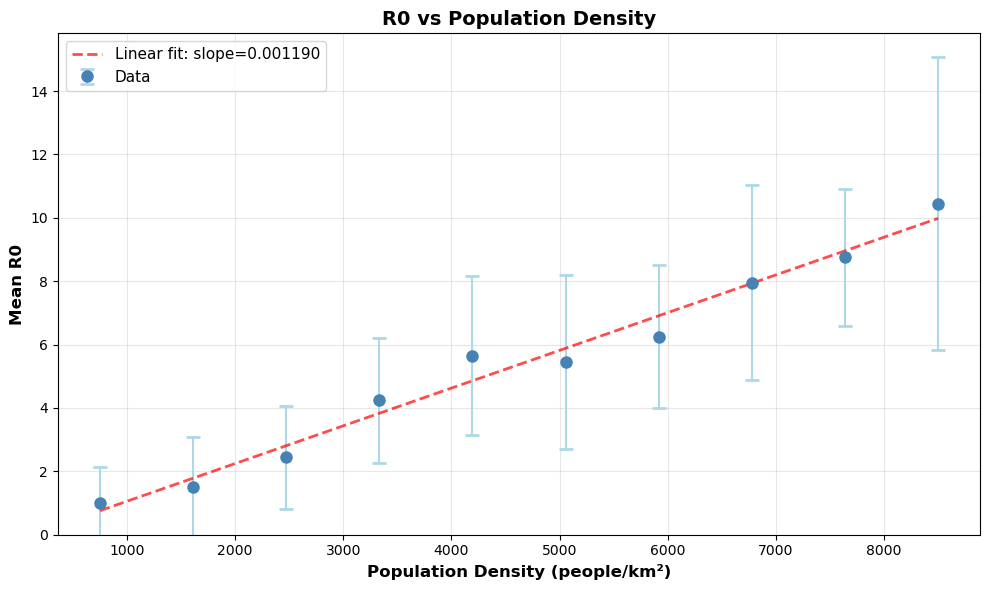


Plot saved to: r0_vs_density.png


In [79]:
from scipy.optimize import curve_fit

print("="*80)
print("R0 VS POPULATION DENSITY SWEEP")
print("="*80)

# Keep N_AGENTS constant, vary grid_size to change density
n_agents_fixed = N_AGENTS  # 750 agents
n_runs_per_density = 20
n_days = 50

# Define densities linearly, then calculate corresponding grid sizes
densities = np.linspace(750, 8500, 10)  # 10 linearly spaced densities
grid_sizes = [np.sqrt(n_agents_fixed / density) for density in densities]

print(f"Fixed number of agents: {n_agents_fixed}")
print(f"Testing {len(densities)} different densities")
print(f"Density range: {min(densities):.0f} to {max(densities):.0f} people/km²")
print(f"Runs per density: {n_runs_per_density}")
print(f"Total simulations: {len(densities) * n_runs_per_density}")

results = []

start_total = time.time()
for i, (density, grid_size) in enumerate(zip(densities, grid_sizes)):
    print(f"\n[{i+1}/{len(densities)}] Testing density = {density:.0f} people/km² (grid = {grid_size:.3f} km)...")
    
    # Run multiple simulations for this density
    start = time.time()
    r0_values = []
    for run in range(n_runs_per_density):
        r0 = simulate_r0(n_agents=n_agents_fixed, grid_size=grid_size, 
                        decay_multiplier=DECAY_MULTIPLIER, n_days=n_days, verbose=False)
        r0_values.append(r0)
    end = time.time()
    
    # Calculate mean and std
    mean_r0 = np.mean(r0_values)
    std_r0 = np.std(r0_values)
    
    # Save density, mean_r0, and std_r0
    results.append({
        'density': density,
        'mean_r0': mean_r0,
        'std_r0': std_r0
    })
    
    print(f"  Mean R0 = {mean_r0:.2f} ± {std_r0:.2f} (time: {end-start:.1f}s)")

end_total = time.time()

# Create DataFrame and save
df_density = pd.DataFrame(results)
df_density.to_csv('r0_vs_density.csv', index=False)

print("\n" + "="*80)
print("DENSITY SWEEP COMPLETE")
print("="*80)
print(f"Total time: {end_total-start_total:.1f} seconds")
print(f"Results saved to: r0_vs_density.csv")
print("\nSummary:")
print(df_density.to_string(index=False))

# Linear function for curve_fit
def linear(x, m, c):
    return m * x + c

# Fit linear model
params, _ = curve_fit(linear, df_density['density'], df_density['mean_r0'])

print("\nLinear fit:")
print(f"  R0 = {params[0]:.6f} × density + {params[1]:.2f}")
print(f"  Slope = {params[0]:.6f}")
print(f"  Intercept = {params[1]:.2f}")

# Plot with error bars and line of best fit
plt.figure(figsize=(10, 6))
plt.errorbar(df_density['density'], df_density['mean_r0'], 
             yerr=df_density['std_r0'], fmt='o', markersize=8, 
             color='steelblue', ecolor='lightblue', capsize=5, capthick=2, 
             label='Data')

# Plot line of best fit
x_fit = np.linspace(df_density['density'].min(), df_density['density'].max(), 200)
y_fit = linear(x_fit, *params)
plt.plot(x_fit, y_fit, 'r--', linewidth=2, alpha=0.7, 
         label=f'Linear fit: slope={params[0]:.6f}')

plt.xlabel('Population Density (people/km²)', fontsize=12, fontweight='bold')
plt.ylabel('Mean R0', fontsize=12, fontweight='bold')
plt.title('R0 vs Population Density', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11)
plt.ylim(bottom=0)
plt.tight_layout()
plt.savefig('r0_vs_density.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: r0_vs_density.png")

cell 5b

R0 VS DECAY MULTIPLIER (RECOVERY TIME) SWEEP
Fixed: 1133 agents, 0.5 km grid
Testing 17 different decay multipliers
Decay multipliers: ['0.20', '0.30', '0.40', '0.50', '0.60', '0.70', '0.80', '0.90', '1.00', '1.10', '1.30', '1.50', '1.70', '1.90', '2.10', '2.30', '2.50']
Runs per multiplier: 20
Total simulations: 340

[1/17] Testing decay_multiplier = 0.20...
  Mean R0 = 45.40 ± 6.03 (time: 4.1s)

[2/17] Testing decay_multiplier = 0.30...
  Mean R0 = 41.50 ± 5.89 (time: 3.9s)

[3/17] Testing decay_multiplier = 0.40...
  Mean R0 = 36.65 ± 6.21 (time: 3.9s)

[4/17] Testing decay_multiplier = 0.50...
  Mean R0 = 33.00 ± 5.97 (time: 3.7s)

[5/17] Testing decay_multiplier = 0.60...
  Mean R0 = 26.85 ± 4.88 (time: 3.5s)

[6/17] Testing decay_multiplier = 0.70...
  Mean R0 = 20.50 ± 3.47 (time: 3.4s)

[7/17] Testing decay_multiplier = 0.80...
  Mean R0 = 14.20 ± 2.80 (time: 3.2s)

[8/17] Testing decay_multiplier = 0.90...
  Mean R0 = 10.45 ± 2.64 (time: 3.1s)

[9/17] Testing decay_multiplier 

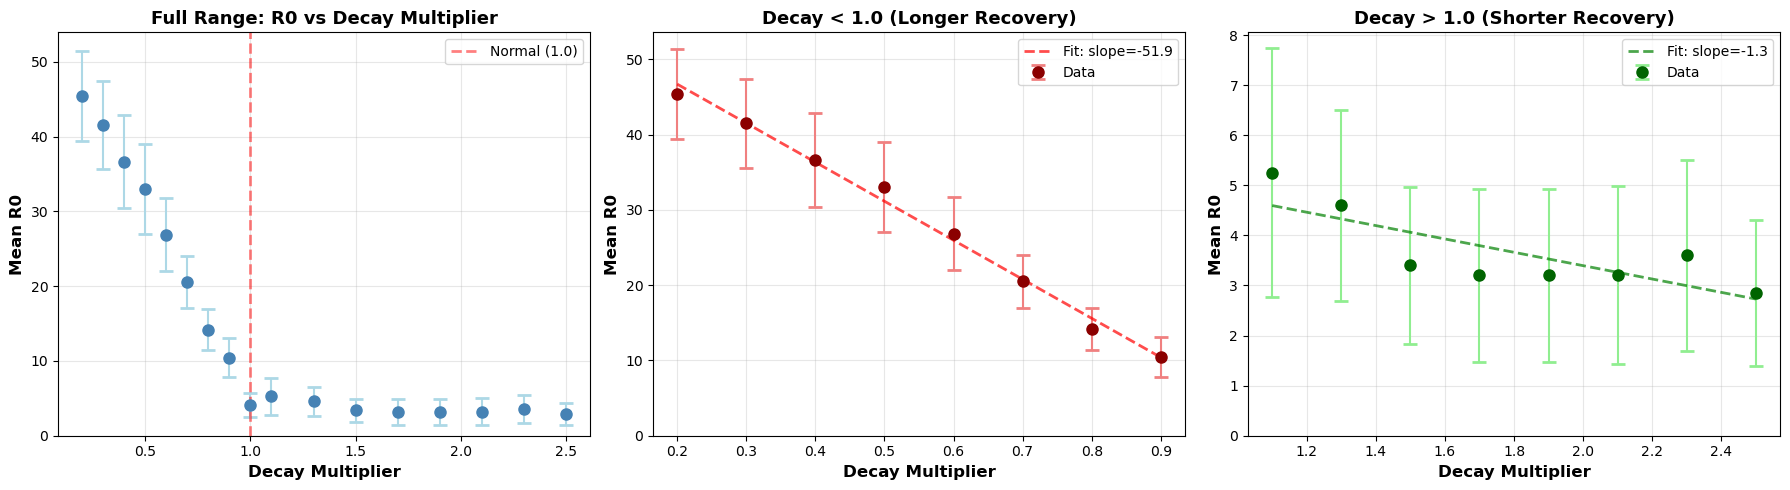


Plot saved to: r0_vs_decay_multiplier.png


In [73]:
from scipy.optimize import curve_fit

print("="*80)
print("R0 VS DECAY MULTIPLIER (RECOVERY TIME) SWEEP")
print("="*80)

# Use default grid_size and n_agents, vary decay_multiplier
n_agents_fixed = N_AGENTS
grid_size_fixed = GRID_SIZE
n_runs_per_multiplier = 20
n_days = 50

# Decay multipliers: 8 points below 1, 1 point at 1, 8 points above 1
decay_multipliers = np.concatenate([
    np.linspace(0.2, 0.9, 8),   # 8 points from 0.2 to 0.9
    [1.0],                       # 1 point at 1
    np.linspace(1.1, 2.5, 8)    # 8 points from 1.1 to 2.5
])

print(f"Fixed: {n_agents_fixed} agents, {grid_size_fixed} km grid")
print(f"Testing {len(decay_multipliers)} different decay multipliers")
print(f"Decay multipliers: {[f'{d:.2f}' for d in decay_multipliers]}")
print(f"Runs per multiplier: {n_runs_per_multiplier}")
print(f"Total simulations: {len(decay_multipliers) * n_runs_per_multiplier}")

results = []

start_total = time.time()
for i, decay_mult in enumerate(decay_multipliers):
    print(f"\n[{i+1}/{len(decay_multipliers)}] Testing decay_multiplier = {decay_mult:.2f}...")
    
    start = time.time()
    r0_values = []
    for run in range(n_runs_per_multiplier):
        r0 = simulate_r0(n_agents=n_agents_fixed, grid_size=grid_size_fixed,
                        decay_multiplier=decay_mult, n_days=n_days, verbose=False)
        r0_values.append(r0)
    end = time.time()
    
    mean_r0 = np.mean(r0_values)
    std_r0 = np.std(r0_values)
    
    results.append({
        'decay_multiplier': decay_mult,
        'mean_r0': mean_r0,
        'std_r0': std_r0
    })
    
    print(f"  Mean R0 = {mean_r0:.2f} ± {std_r0:.2f} (time: {end-start:.1f}s)")

end_total = time.time()

df_decay = pd.DataFrame(results)
df_decay.to_csv('r0_vs_decay_multiplier.csv', index=False)

print("\n" + "="*80)
print("DECAY MULTIPLIER SWEEP COMPLETE")
print("="*80)
print(f"Total time: {end_total-start_total:.1f} seconds")
print(f"Results saved to: r0_vs_decay_multiplier.csv")
print("\nSummary:")
print(df_decay.to_string(index=False))

# Split data into two regimes
df_less_than_1 = df_decay[df_decay['decay_multiplier'] < 1.0].copy()
df_greater_than_1 = df_decay[df_decay['decay_multiplier'] > 1.0].copy()

# Linear function for curve_fit
def linear(x, m, c):
    return m * x + c

# Fit linear models
params_low, _ = curve_fit(linear, df_less_than_1['decay_multiplier'], df_less_than_1['mean_r0'])
params_high, _ = curve_fit(linear, df_greater_than_1['decay_multiplier'], df_greater_than_1['mean_r0'])

print("\nLinear fits:")
print(f"  Decay < 1.0: R0 = {params_low[0]:.2f} × decay + {params_low[1]:.2f}")
print(f"  Decay > 1.0: R0 = {params_high[0]:.2f} × decay + {params_high[1]:.2f}")

# Create three-panel plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Full data with error bars
ax1 = axes[0]
ax1.errorbar(df_decay['decay_multiplier'], df_decay['mean_r0'], 
             yerr=df_decay['std_r0'], fmt='o', markersize=8, 
             color='steelblue', ecolor='lightblue', capsize=5, capthick=2)
ax1.axvline(x=1.0, color='red', linestyle='--', alpha=0.5, linewidth=2, label='Normal (1.0)')
ax1.set_xlabel('Decay Multiplier', fontsize=12, fontweight='bold')
ax1.set_ylabel('Mean R0', fontsize=12, fontweight='bold')
ax1.set_title('Full Range: R0 vs Decay Multiplier', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)
ax1.set_ylim(bottom=0)

# Plot 2: Decay < 1.0
ax2 = axes[1]
ax2.errorbar(df_less_than_1['decay_multiplier'], df_less_than_1['mean_r0'], 
             yerr=df_less_than_1['std_r0'], fmt='o', markersize=8,
             color='darkred', ecolor='lightcoral', capsize=5, capthick=2, label='Data')
# Plot line of best fit
x_fit = np.linspace(df_less_than_1['decay_multiplier'].min(), 
                    df_less_than_1['decay_multiplier'].max(), 100)
y_fit = linear(x_fit, *params_low)
ax2.plot(x_fit, y_fit, 'r--', linewidth=2, alpha=0.7, 
         label=f'Fit: slope={params_low[0]:.1f}')
ax2.set_xlabel('Decay Multiplier', fontsize=12, fontweight='bold')
ax2.set_ylabel('Mean R0', fontsize=12, fontweight='bold')
ax2.set_title('Decay < 1.0 (Longer Recovery)', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)
ax2.set_ylim(bottom=0)

# Plot 3: Decay > 1.0
ax3 = axes[2]
ax3.errorbar(df_greater_than_1['decay_multiplier'], df_greater_than_1['mean_r0'], 
             yerr=df_greater_than_1['std_r0'], fmt='o', markersize=8,
             color='darkgreen', ecolor='lightgreen', capsize=5, capthick=2, label='Data')
# Plot line of best fit
x_fit = np.linspace(df_greater_than_1['decay_multiplier'].min(), 
                    df_greater_than_1['decay_multiplier'].max(), 100)
y_fit = linear(x_fit, *params_high)
ax3.plot(x_fit, y_fit, 'g--', linewidth=2, alpha=0.7,
         label=f'Fit: slope={params_high[0]:.1f}')
ax3.set_xlabel('Decay Multiplier', fontsize=12, fontweight='bold')
ax3.set_ylabel('Mean R0', fontsize=12, fontweight='bold')
ax3.set_title('Decay > 1.0 (Shorter Recovery)', fontsize=13, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=10)
ax3.set_ylim(bottom=0)

plt.tight_layout()
plt.savefig('r0_vs_decay_multiplier.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nPlot saved to: r0_vs_decay_multiplier.png")

Cell 6

In [37]:
def simulate_epidemic(n_days=SIMULATION_DAYS, initial_infected=INITIAL_INFECTED, verbose=True):
    """
    Optimized epidemic simulation
    """
    agents = initialize_population(N_AGENTS, initial_infected, for_r0_calculation=False)
    
    # Track unique agents that have ever been infected
    ever_infected_ids = set()
    
    # Add initial infected to the set
    for agent in agents:
        if agent.status == 'infected':
            ever_infected_ids.add(id(agent))
    
    stats = {
        'day': [],
        'susceptible': [],
        'infected': [],
        'recovered': [],
        'cumulative_infections': []
    }
    
    for day in range(n_days):
        # Move all agents
        for agent in agents:
            agent.move(D, DT)
        
        # Attempt transmissions
        new_infections = transmission_step_optimized(agents, for_r0_calculation=False)
        
        # Update set of ever-infected agents
        for agent in agents:
            if agent.status == 'infected':
                ever_infected_ids.add(id(agent))
        
        # Update infection status
        for agent in agents:
            agent.update_infection_status()
        
        # Record statistics (only count when needed for verbose output or storage)
        n_susceptible = sum(1 for a in agents if a.status == 'susceptible')
        n_infected = sum(1 for a in agents if a.status == 'infected')
        n_recovered = sum(1 for a in agents if a.status == 'recovered')
        cumulative = len(ever_infected_ids)
        
        stats['day'].append(day)
        stats['susceptible'].append(n_susceptible)
        stats['infected'].append(n_infected)
        stats['recovered'].append(n_recovered)
        stats['cumulative_infections'].append(cumulative)
        
        if verbose and day % 10 == 0:
            print(f"Day {day}: S={n_susceptible}, I={n_infected}, R={n_recovered}, Cumulative={cumulative}")
    
    if verbose:
        final_cumulative = stats['cumulative_infections'][-1]
        print(f"\nFinal statistics:")
        print(f"Total infected: {final_cumulative} ({100*final_cumulative/N_AGENTS:.1f}%)")
        print(f"Final recovered: {stats['recovered'][-1]}")
        print(f"Remaining susceptible: {stats['susceptible'][-1]}")
    
    return stats, agents

# Run full epidemic simulation
print("\n" + "="*60)
print("RUNNING FULL EPIDEMIC SIMULATION")
print("="*60)
start = time.time()
epidemic_stats, final_agents = simulate_epidemic()
end = time.time()
print(f"\nComputation time: {end-start:.2f} seconds")


RUNNING FULL EPIDEMIC SIMULATION
Day 0: S=1132, I=1, R=0, Cumulative=1
Day 10: S=1104, I=28, R=1, Cumulative=29
Day 20: S=489, I=637, R=7, Cumulative=644
Day 30: S=6, I=909, R=218, Cumulative=1127
Day 40: S=1, I=21, R=1111, Cumulative=1132

Final statistics:
Total infected: 1132 (99.9%)
Final recovered: 1131
Remaining susceptible: 1

Computation time: 2.42 seconds


Cell 7

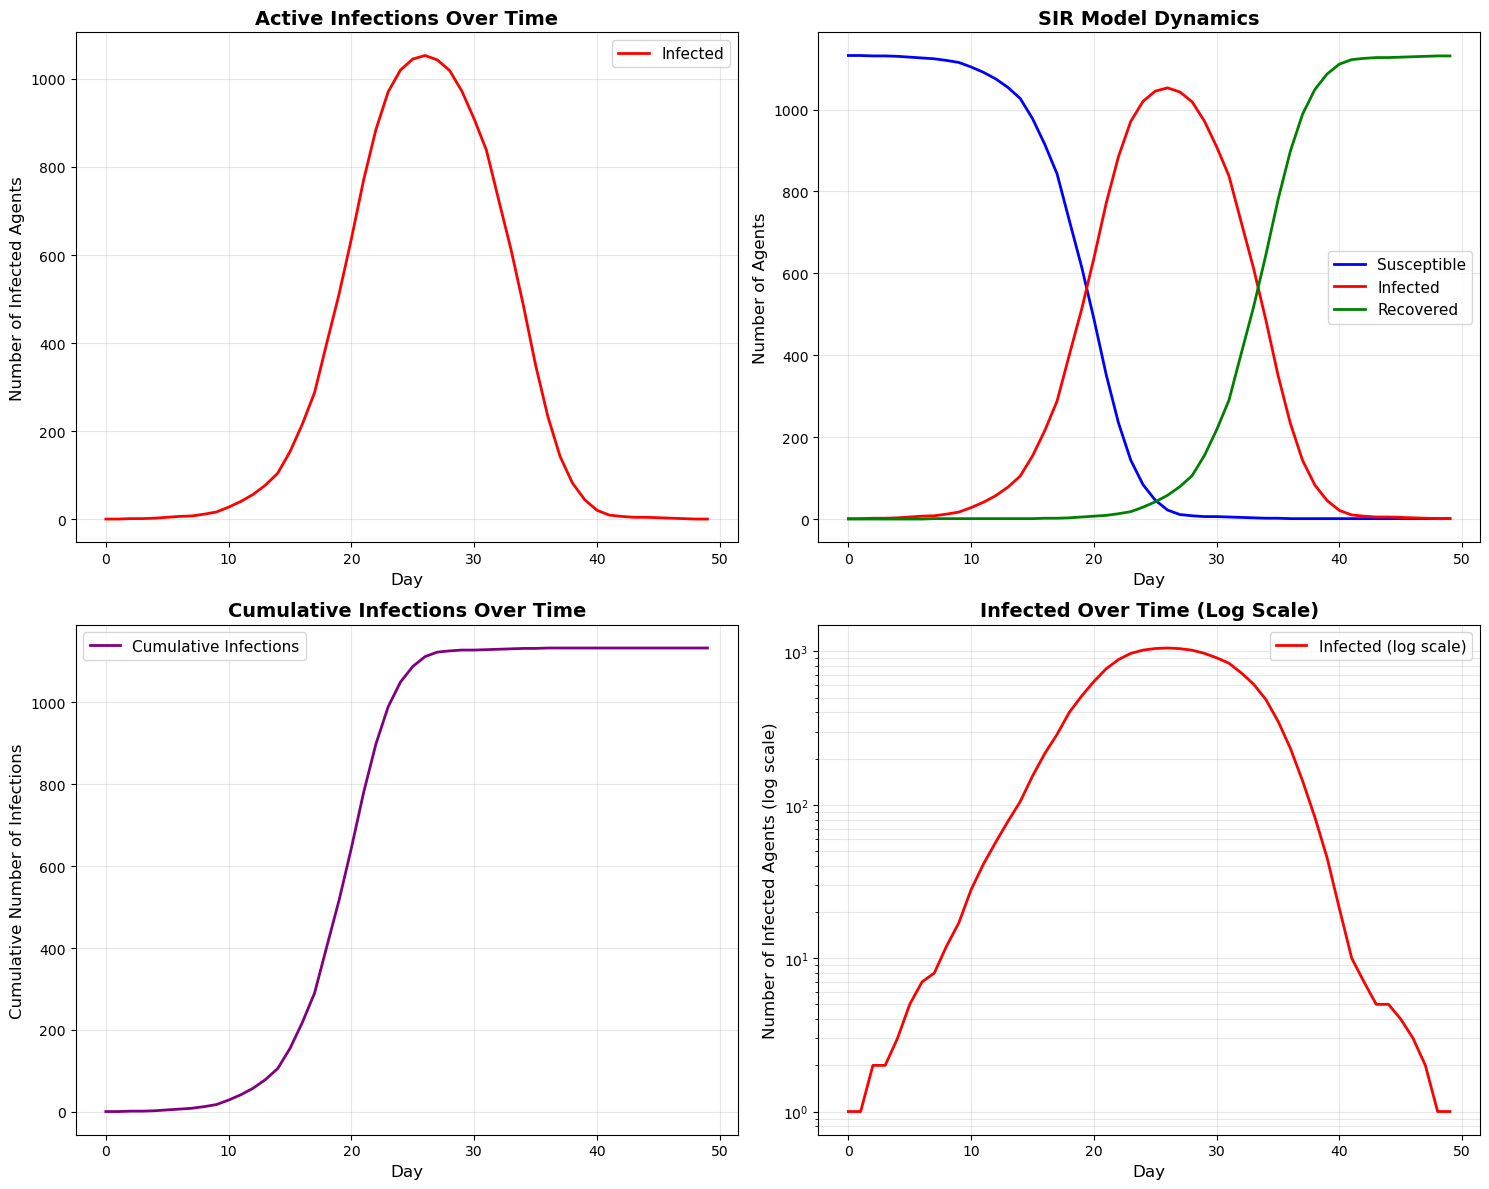


Visualization complete! Saved as 'covid_simulation_results.png'


In [39]:

fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Infected over time
ax1 = axes[0, 0]
ax1.plot(epidemic_stats['day'], epidemic_stats['infected'], 'r-', linewidth=2, label='Infected')
ax1.set_xlabel('Day', fontsize=12)
ax1.set_ylabel('Number of Infected Agents', fontsize=12)
ax1.set_title('Active Infections Over Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=11)

# Plot 2: All compartments
ax2 = axes[0, 1]
ax2.plot(epidemic_stats['day'], epidemic_stats['susceptible'], 'b-', linewidth=2, label='Susceptible')
ax2.plot(epidemic_stats['day'], epidemic_stats['infected'], 'r-', linewidth=2, label='Infected')
ax2.plot(epidemic_stats['day'], epidemic_stats['recovered'], 'g-', linewidth=2, label='Recovered')
ax2.set_xlabel('Day', fontsize=12)
ax2.set_ylabel('Number of Agents', fontsize=12)
ax2.set_title('SIR Model Dynamics', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=11)

# Plot 3: Cumulative infections
ax3 = axes[1, 0]
ax3.plot(epidemic_stats['day'], epidemic_stats['cumulative_infections'], 'purple', linewidth=2, label='Cumulative Infections')
ax3.set_xlabel('Day', fontsize=12)
ax3.set_ylabel('Cumulative Number of Infections', fontsize=12)
ax3.set_title('Cumulative Infections Over Time', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.legend(fontsize=11)

# Plot 4: Log scale for infected (to see exponential growth)
ax4 = axes[1, 1]
infected_nonzero = [max(i, 0.1) for i in epidemic_stats['infected']]  # Avoid log(0)
ax4.semilogy(epidemic_stats['day'], infected_nonzero, 'r-', linewidth=2, label='Infected (log scale)')
ax4.set_xlabel('Day', fontsize=12)
ax4.set_ylabel('Number of Infected Agents (log scale)', fontsize=12)
ax4.set_title('Infected Over Time (Log Scale)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, which='both')
ax4.legend(fontsize=11)

plt.tight_layout()
plt.savefig('covid_simulation_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization complete! Saved as 'covid_simulation_results.png'")

Cell 8

RE-RUNNING EPIDEMIC TO CAPTURE SPATIAL SNAPSHOTS
Day 0: S=1132, I=1, R=0
Day 10: S=1108, I=24, R=1
Day 20: S=460, I=665, R=8
Day 30: S=1, I=914, R=218
Day 40: S=0, I=23, R=1110
Day 50: S=0, I=0, R=1133

Snapshots captured!


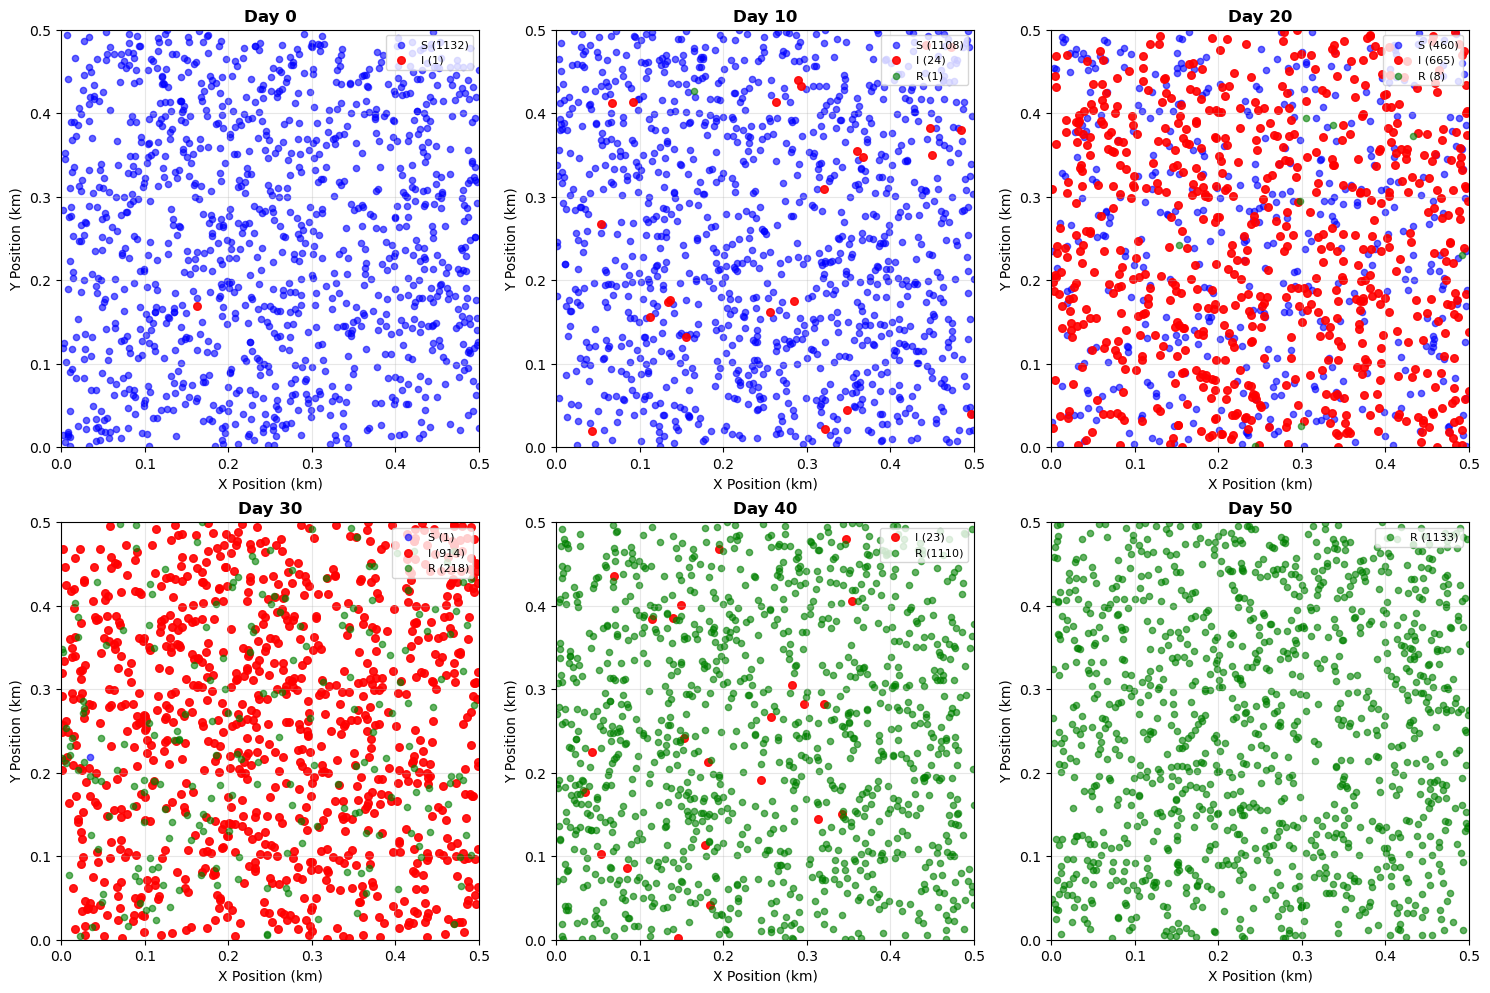


Spatial snapshots saved to: spatial_snapshots.png


In [56]:
# Visualize spatial distribution at multiple time points
# We need to re-run the simulation and save snapshots

print("="*60)
print("RE-RUNNING EPIDEMIC TO CAPTURE SPATIAL SNAPSHOTS")
print("="*60)

# Re-run simulation with snapshot saving
agents = initialize_population(N_AGENTS, INITIAL_INFECTED, for_r0_calculation=False)
ever_infected_ids = set()

# Add initial infected to the set
for agent in agents:
    if agent.status == 'infected':
        ever_infected_ids.add(id(agent))

# Store snapshots at 10-day intervals
snapshots = {}
snapshot_days = list(range(0, SIMULATION_DAYS + 1, 10))  # [0, 10, 20, 30, 40, 50]

for day in range(SIMULATION_DAYS + 1):
    # Move all agents
    if day > 0:  # Don't move on day 0
        for agent in agents:
            agent.move(D, DT)
        
        # Attempt transmissions
        new_infections = transmission_step_optimized(agents, for_r0_calculation=False)
        
        # Update set of ever-infected agents
        for agent in agents:
            if agent.status == 'infected':
                ever_infected_ids.add(id(agent))
        
        # Update infection status
        for agent in agents:
            agent.update_infection_status()
    
    # Save snapshot at 10-day intervals
    if day in snapshot_days:
        # Deep copy the agent states
        snapshot = {
            'day': day,
            'susceptible': [(a.x, a.y) for a in agents if a.status == 'susceptible'],
            'infected': [(a.x, a.y) for a in agents if a.status == 'infected'],
            'recovered': [(a.x, a.y) for a in agents if a.status == 'recovered']
        }
        snapshots[day] = snapshot
        print(f"Day {day}: S={len(snapshot['susceptible'])}, I={len(snapshot['infected'])}, R={len(snapshot['recovered'])}")

print("\nSnapshots captured!")

# Create subplots for all time points
n_snapshots = len(snapshot_days)
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, day in enumerate(snapshot_days):
    ax = axes[i]
    snapshot = snapshots[day]
    
    # Plot susceptible
    if snapshot['susceptible']:
        s_x, s_y = zip(*snapshot['susceptible'])
        ax.scatter(s_x, s_y, c='blue', s=20, alpha=0.6, label=f'S ({len(snapshot["susceptible"])})')
    
    # Plot infected
    if snapshot['infected']:
        i_x, i_y = zip(*snapshot['infected'])
        ax.scatter(i_x, i_y, c='red', s=30, alpha=0.9, label=f'I ({len(snapshot["infected"])})')
    
    # Plot recovered
    if snapshot['recovered']:
        r_x, r_y = zip(*snapshot['recovered'])
        ax.scatter(r_x, r_y, c='green', s=20, alpha=0.6, label=f'R ({len(snapshot["recovered"])})')
    
    ax.set_xlabel('X Position (km)', fontsize=10)
    ax.set_ylabel('Y Position (km)', fontsize=10)
    ax.set_title(f'Day {day}', fontsize=12, fontweight='bold')
    ax.set_xlim(0, GRID_SIZE)
    ax.set_ylim(0, GRID_SIZE)
    ax.legend(fontsize=8, loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('spatial_snapshots.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nSpatial snapshots saved to: spatial_snapshots.png")

Cell 9

In [274]:

# Create summary statistics
summary = pd.DataFrame({
    'Parameter': [
        'Grid Size', 
        'Population', 
        'Population Density',
        'Diffusion Coefficient (D)',
        'Expected Daily Movement (RMS)',
        'Simulation Days',
        'Basic Reproduction Number (R0)',
        'Peak Infected',
        'Day of Peak',
        'Total Ever Infected',
        'Attack Rate (%)',
        'Final Susceptible'
    ],
    'Value': [
        f'{GRID_SIZE} km × {GRID_SIZE} km',
        N_AGENTS,
        f'{POPULATION_DENSITY} per km²',
        f'{D} km²/day',
        f'{np.sqrt(2*D*DT):.2f} km/day',
        SIMULATION_DAYS,
        f'{r0_value:.2f}',
        max(epidemic_stats['infected']),
        epidemic_stats['infected'].index(max(epidemic_stats['infected'])),
        epidemic_stats['cumulative_infections'][-1],
        f"{100 * epidemic_stats['cumulative_infections'][-1] / N_AGENTS:.1f}%",
        epidemic_stats['susceptible'][-1]
    ]
})

print("\n" + "="*60)
print("SIMULATION SUMMARY")
print("="*60)
print(summary.to_string(index=False))
print("="*60)

# Save to CSV
summary.to_csv('simulation_summary.csv', index=False)
print("\nSummary saved to 'simulation_summary.csv'")


SIMULATION SUMMARY
                     Parameter           Value
                     Grid Size 0.5 km × 0.5 km
                    Population             750
            Population Density    3000 per km²
     Diffusion Coefficient (D)    12.5 km²/day
 Expected Daily Movement (RMS)     5.00 km/day
               Simulation Days              50
Basic Reproduction Number (R0)            2.00
                 Peak Infected             622
                   Day of Peak              24
           Total Ever Infected             748
               Attack Rate (%)           99.7%
             Final Susceptible               2

Summary saved to 'simulation_summary.csv'
